In [1]:
import numpy as np
import matplotlib.pyplot as plt
from inference.gp import GpRegressor # inference-tools package
from inference.gp import SquaredExponential, WhiteNoise

Gather the data

In [5]:
data = np.genfromtxt("data/step_results.csv", delimiter=",", names=True)

Train the GP model

In [6]:
training_points = [(tau, eta) for tau, eta in zip(data["tau_bzs"], data["eta_TES"])]
composite_kernel = SquaredExponential() + WhiteNoise()
GP_startup_inv = GpRegressor(training_points, data["I_stkg"], kernel=composite_kernel)
GP_tbr = GpRegressor(training_points, data["TBR"], kernel=composite_kernel)
# @Samuele, what kernel did you use in Matlab?

Sample space for plotting

In [7]:
N_tau = 100
N_eta = 100
tau_refined = np.linspace(0, data["tau_bzs"].max(), num=N_tau)
eta_TES_refined = np.linspace(0, data["eta_TES"].max(), num=N_eta)
XX, YY = np.meshgrid(tau_refined, eta_TES_refined)
grid = XX, YY

gp_coords = np.append(grid[0].reshape(-1,1), grid[1].reshape(-1,1),axis=1)

mean_startup_inv, stdev_startup_inv = GP_startup_inv(gp_coords)
mean_tbr, stdev_tbr = GP_tbr(gp_coords)

Plot

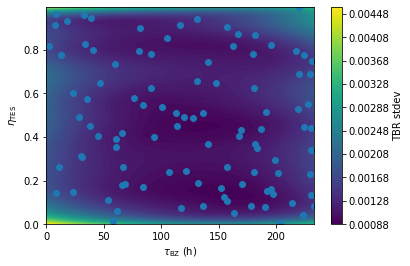

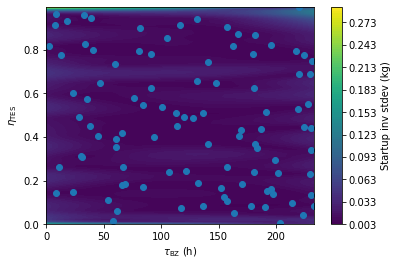

In [8]:
for stdev, label in zip([stdev_tbr, stdev_startup_inv], ["TBR stdev", "Startup inv stdev (kg)"]):

    CF = plt.contourf(XX/3600, YY, stdev.reshape([N_tau, N_eta]), levels=100)

    plt.scatter(data["tau_bzs"]/3600, data["eta_TES"])
    plt.colorbar(CF, label=label)
    plt.xlabel(r"$\tau_\mathrm{BZ}$ (h)")
    plt.ylabel(r"$\eta_\mathrm{TES}$")
    plt.show()


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


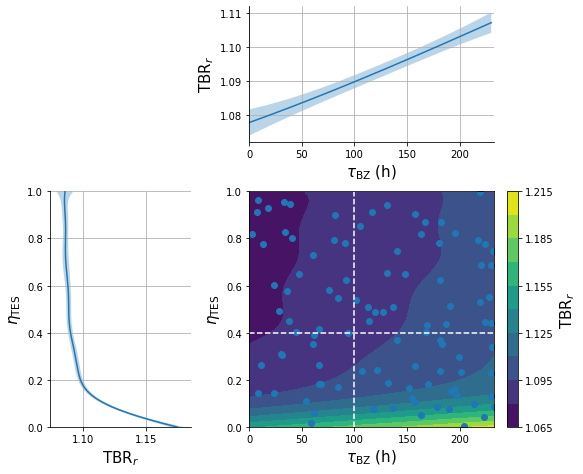

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


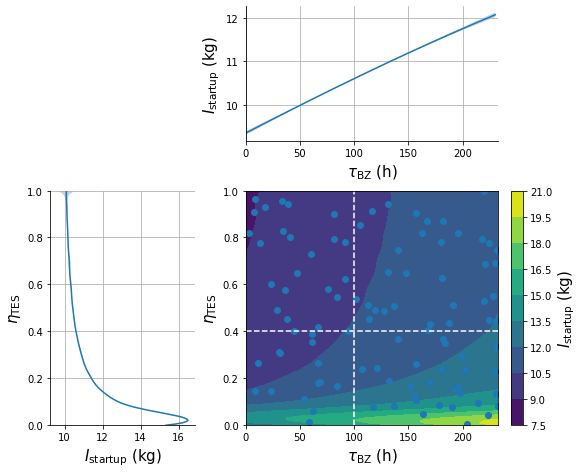

In [9]:
fixed_eta = 0.4
fixed_tau = 100*3600


for gp, mean_metric, label in zip([GP_tbr, GP_startup_inv], [mean_tbr, mean_startup_inv], ["TBR$_r$", r"$I_\mathrm{startup}$ (kg)"]):
    fig, axs = plt.subplots(2, 2, figsize=(8, 6.48), constrained_layout=True, sharex="col", sharey="row",
                        gridspec_kw={
                            'width_ratios': [1.15, 2],
                            'height_ratios': [1.15, 2]})
    # 0, 0
    axs[0][0].axis('off')

    contour_ax = axs[1][1]
    top_ax = axs[0][1]
    left_ax = axs[1][0]


    plt.sca(contour_ax)

    CF = plt.contourf(XX/3600, YY, mean_metric.reshape([N_tau, N_eta]), levels=8)

    plt.scatter(data["tau_bzs"]/3600, data["eta_TES"])

    plt.axvline(x=fixed_tau/3600, linestyle="dashed", color="white")
    plt.axhline(y=fixed_eta, linestyle="dashed", color="white")

    plt.sca(top_ax)
    tau_bz = np.linspace(0, 230*3600, num=200)

    pts = [(tau, fixed_eta) for tau in tau_bz]

    mean, stdev = gp(pts)

    plt.plot(tau_bz/3600, mean)
    plt.fill_between(tau_bz/3600, mean - 2*stdev, mean + 2*stdev, alpha=0.3)

    plt.sca(left_ax)

    eta_tes = np.linspace(0, 1, num=200)

    pts = [(fixed_tau, eta) for eta in eta_tes]

    mean, stdev = gp(pts)

    plt.plot(mean, eta_tes)
    plt.fill_betweenx(eta_tes, mean - 2*stdev, mean + 2*stdev, alpha=0.3)

    cb = fig.colorbar(CF, ax=contour_ax)
    cb.set_label(label=label, fontsize=15)
    left_ax.set_xlabel(label, fontsize=15)
    top_ax.set_ylabel(label, fontsize=15)
    contour_ax.set_xlabel(r"$\tau_\mathrm{BZ}$ (h)", fontsize=15)
    top_ax.set_xlabel(r"$\tau_\mathrm{BZ}$ (h)", fontsize=15)
    left_ax.set_ylabel(r"$\eta_\mathrm{TES}$", fontsize=15)
    contour_ax.set_ylabel(r"$\eta_\mathrm{TES}$", fontsize=15)

    contour_ax.set_ylim(0, 1)
    # top_ax.set_ylim(bottom=1)

    left_ax.grid()
    top_ax.grid()

    top_ax.xaxis.set_tick_params(which='both', labelbottom=True)
    top_ax.yaxis.set_tick_params(which='both', labelleft=True)
    contour_ax.yaxis.set_tick_params(which='both', labelleft=True)


    left_ax.spines.top.set_visible(False)
    left_ax.spines.right.set_visible(False)

    top_ax.spines.top.set_visible(False)
    top_ax.spines.right.set_visible(False)
    plt.savefig(f"{label}_step_2d_map.eps".replace(" ", "_").replace("(kg)", "").replace("$I_\\mathrm{startup}$", "I_startup"), format='eps')
    plt.show()